# <font style="color:rgb(50,120,229)">Transfer Learning and Fine-tuning </font>
In this chapter, we will learn how to fine-tune a pre-trained model for a different task than it was originally trained for.

When we train a network from scratch, we encounter the following two limitations :

- Huge data required - Since the network has millions of parameters, to get an optimal set of parameters, we need to have a lot of data.
- Huge computing power required - Even if we have a lot of data, training generally requires multiple iterations and it takes a toll on the computing resources.

The pre-trained models are trained on very large scale image classification problems. The convolutional layers act as feature extractor and the fully connected layers act as Classifiers.

Since these models are very large and have seen a huge number of images, they tend to learn very good, discriminative features. We can either use the convolutional layers merely as a feature extractor and change the last layer according to our problem or we can tweak the already trained convolutional layers to suit our problem at hand. The former approach is known as **Transfer Learning** and the latter as **Fine-tuning**.

The task of fine-tuning a network is to tweak the parameters of an already trained network so that it adapts to the new task at hand. The initial layers of a network learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact ( or freeze them ) and retrain the later layers for our task.

Thus, fine-tuning avoids both the limitations discussed above.

The amount of data required for training is not much because of two reasons. 
- First, we are not training the entire network. Second, the part that is being trained is not trained from scratch.
- Since the parameters that need to be updated is less, the amount of time needed will also be less.

As a rule of thumb, when we have a small training set and our problem is similar to the task for which the pre-trained models were trained, we can use transfer learning. If we have enough data, we can try and tweak the convolutional layers so that they learn more robust features relevant to our problem. You can get a detailed overview of Fine-tuning and transfer learning [here](http://cs231n.github.io/transfer-learning/).

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os,shutil

TensorFlow 2.x selected.
2.1.0-rc1


## <font style="color:rgb(50,120,229)">Loading kaggle dataset</font>
We have already discussed how to load kaggle datasets in the previous section. We will be using the [kaggle dataset](https://www.kaggle.com/sriramr/apples-bananas-oranges) on fruits. The interesting thing about this dataset is is that it contains 6 classes - 3 of which belong to normal fruits and 3 to rotten fruits!

NOTE: You will need to use your API token from kaggle ( kaggle.json file ) for downloading the kaggle dataset on colab. You can also upload the dataset manually to your google drive for doing the experiment.

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sriramr/apples-bananas-oranges

# Unzip all files and suppress output
!unzip -q apples-bananas-oranges.zip 

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes
 96% 489M/512M [00:07<00:00, 35.6MB/s]
100% 512M/512M [00:07<00:00, 67.5MB/s]


In [0]:
# This folder contians all the class folders
main_path = 'original_data_set/original_data_set/'

In [4]:
# all class names
classnames = os.listdir(main_path)
print(classnames)

['freshbanana', 'freshapples', 'rottenbanana', 'rottenoranges', 'freshoranges', 'rottenapples']


In [5]:
# See how many images you have per class, this helps you set the required percentage of validation data.
for each_class in classnames:
  print("Class: {}, has {} samples".format( each_class,len(os.listdir(os.path.join(main_path,each_class )))))

Class: freshbanana, has 218 samples
Class: freshapples, has 232 samples
Class: rottenbanana, has 306 samples
Class: rottenoranges, has 222 samples
Class: freshoranges, has 206 samples
Class: rottenapples, has 328 samples


## <font style="color:rgb(50,120,229)">Arrange your Data</font>
We have already explained in the previous section how the data should be arranged in order to feed it to a training pipeline in Keras.

Here we are going to place the data neatly in train and validation folders inside a main folder called 'fruits' (change the name if you want), you can set the percentage of validation set. We have set it to 15%. So 15% of images from each class will go to validation folder and the rest to train folder.

In [6]:
#!rm -r fruits

base_dir= 'fruits'

total_train_images = 0
total_val_images = 0

os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation') 
os.mkdir(validation_dir)

# Set the percent of validation data you want.
validation_percent = 15

for each_class in classnames:

  source_directory = os.path.join(main_path,each_class )
  destination_train_directory = os.path.join(train_dir,each_class)
  destination_validation_directory = os.path.join(validation_dir,each_class)


  total_image_count = len(os.listdir(source_directory))

  valid_image_count = int(np.floor(total_image_count * (validation_percent/100)))

  train_images_count = int( total_image_count - valid_image_count )

  total_train_images +=  train_images_count
  total_val_images += valid_image_count

  os.mkdir(destination_train_directory)
  os.mkdir(destination_validation_directory)

  # copying the data to class's train folder
  file_names = os.listdir(source_directory)[:train_images_count]

  for fname in file_names:
      src = os.path.join(source_directory, fname)
      dst = os.path.join(destination_train_directory, fname)
      shutil.copyfile(src, dst)


  # Copying the data to class's validation folder
  file_names = os.listdir(source_directory)[train_images_count:]

  for fname in file_names:
      src = os.path.join(source_directory, fname)
      dst = os.path.join(destination_validation_directory, fname)
      shutil.copyfile(src, dst)
  
  print('total training {} images: {}'.format(each_class, len(os.listdir(destination_train_directory))))
  print('total validation {} images: {}'.format(each_class, len(os.listdir(destination_validation_directory))))

total training freshbanana images: 186
total validation freshbanana images: 32
total training freshapples images: 198
total validation freshapples images: 34
total training rottenbanana images: 261
total validation rottenbanana images: 45
total training rottenoranges images: 189
total validation rottenoranges images: 33
total training freshoranges images: 176
total validation freshoranges images: 30
total training rottenapples images: 279
total validation rottenapples images: 49


## <font style="color:rgb(50,120,229)">Freeze the required layers</font>
In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, we should set this parameter to `False`, indicating that this layer should not be trained. That’s it! We go over each layer and select which layers we want to train.

```
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
```

## <font style="color:rgb(50,120,229)">Experiment 1: Freezing all layers - Same as Transfer Learning</font>

In [1]:
from tensorflow.keras.applications import VGG16

image_size = 224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

58892288/58889256 [==============================] - 39s 1us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x137efcf90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x137f5a610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x137f7a550> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x137f7a950> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x137fabf90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x137fabad0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x137fe75d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1381209d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13810dc50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1382f3090> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1382fb5d0> False
<tensorflow.python.keras.layer

NameError: name 'classnames' is not defined

## <font style="color:rgb(50,120,229)">Setup the data generators</font>

We have already separated the data into train and validation and kept it in the “train” and “validation” folders. We can use ImageDataGenerator available in Keras to read images in batches directly from these folders and optionally perform data augmentation. We will use two different data generators for train and validation folders.

In [8]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.


## <font style="color:rgb(50,120,229)">Train the model</font>
Till now, we have created the model and set up the data for training. So, we should proceed with the training and check out the performance. We will have to specify the optimizer and the learning rate and start training using the model.fit() function. After the training is over, we will save the model.

In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)



Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64.45 steps, validate for 11.15 steps
Epoch 1/20
65/64 [==============================] - 16s 248ms/step - loss: 1.1181 - acc: 0.6354 - val_loss: 0.4413 - val_acc: 0.8161
Epoch 2/20
65/64 [==============================] - 9s 137ms/step - loss: 0.4195 - acc: 0.8456 - val_loss: 0.2659 - val_acc: 0.9193
Epoch 3/20
65/64 [==============================] - 9s 134ms/step - loss: 0.3021 - acc: 0.9030 - val_loss: 0.2469 - val_acc: 0.9283
Epoch 4/20
65/64 [==============================] - 9s 135ms/step - loss: 0.2309 - acc: 0.9116 - val_loss: 0.1823 - val_acc: 0.9417
Epoch 5/20
65/64 [==============================] - 9s 135ms/step - loss: 0.1997 - acc: 0.9356 - val_loss: 0.1348 - val_acc: 0.9686
Epoch 6/20
65/64 [==============================] - 9s 136ms/step - loss: 0.1538 - acc: 0.9457 - val_loss: 0.1526 - val_acc: 0.9596
Epoch 7/20
65/64 [===============

## <font style="color:rgb(50,120,229)">Save the model</font>
Keras models are saved in h5 format. You can just use the save method along with the name of the file you want.


In [0]:
# Save the Model
model.save('all_freezed.h5')

In [0]:
# If you want to download your Model run this, you can also download it from the files tab on the left
from google.colab import files
files.download('all_freezed.h5')

## <font style="color:rgb(50,120,229)">Check Performance</font>

Let us see the loss and accuracy curves.

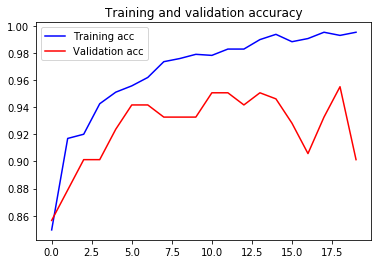

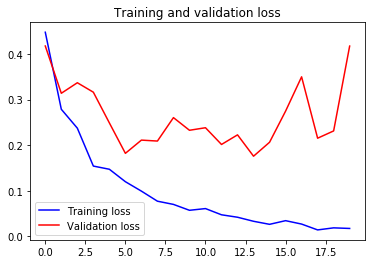

In [0]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## <font style="color:rgb(50,120,229)">Show the errors</font>
Also, let us visually see the errors that we got.


Found 223 images belonging to 6 classes.
12/11 [================================] - 3s 217ms/step
No of errors = 22/223


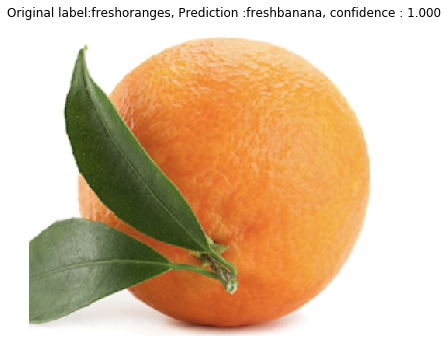

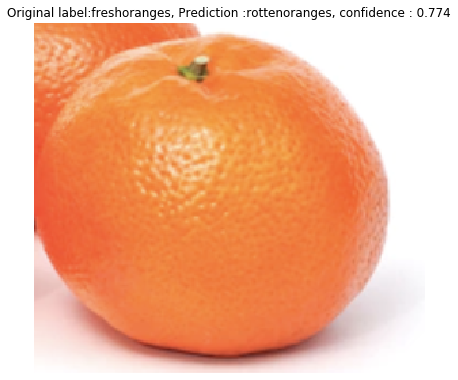

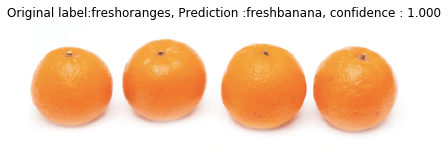

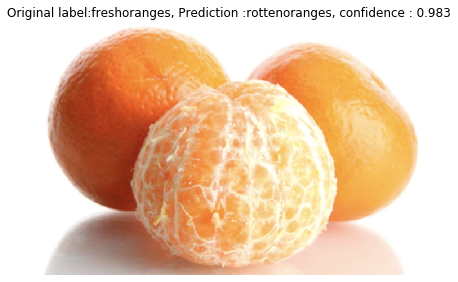

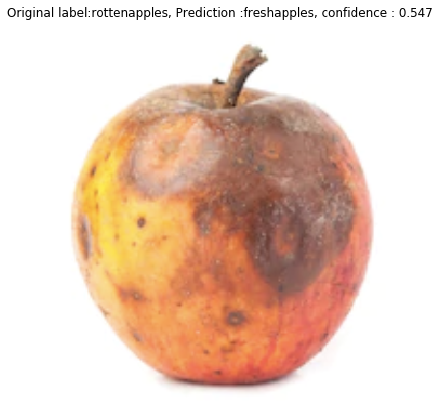

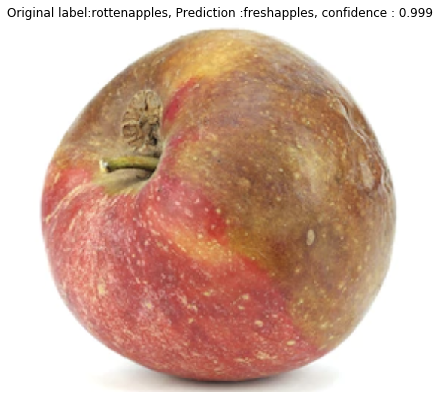

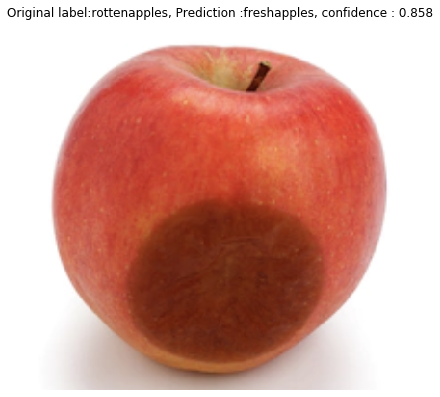

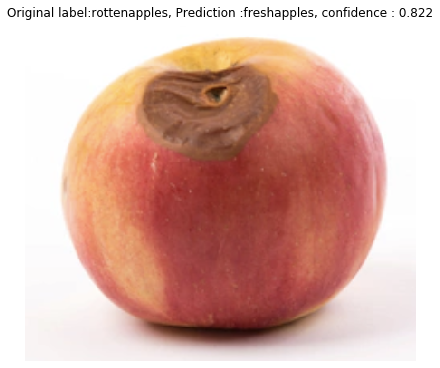

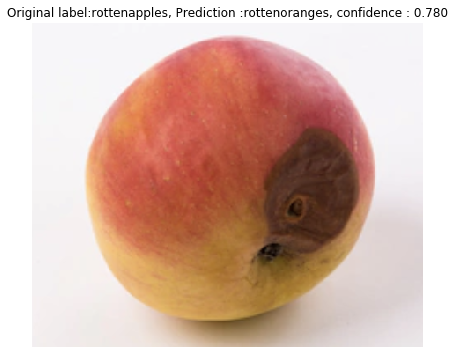

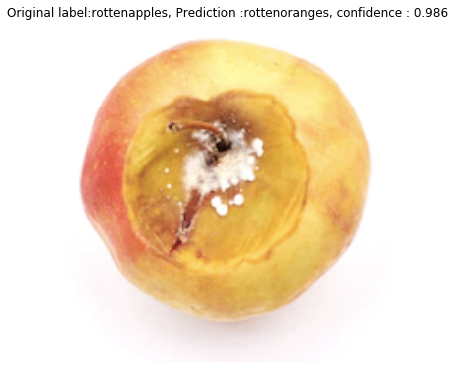

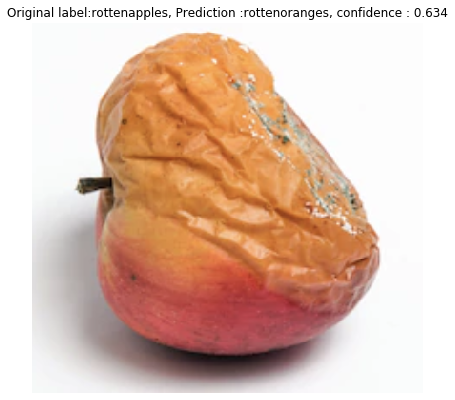

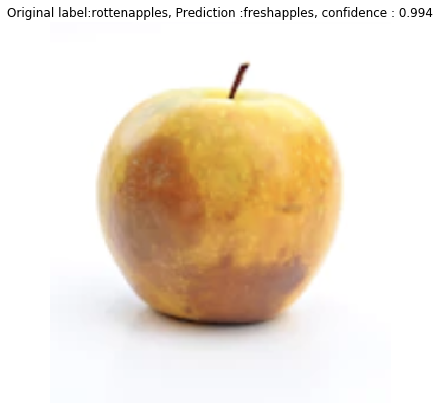

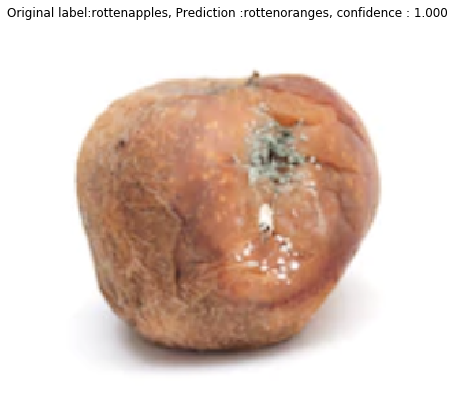

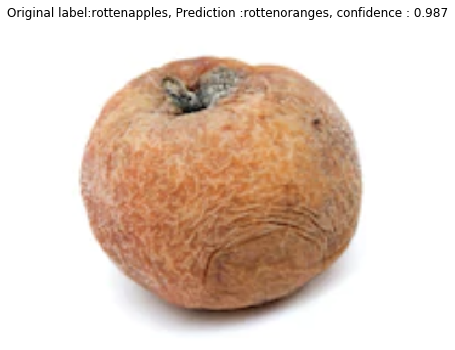

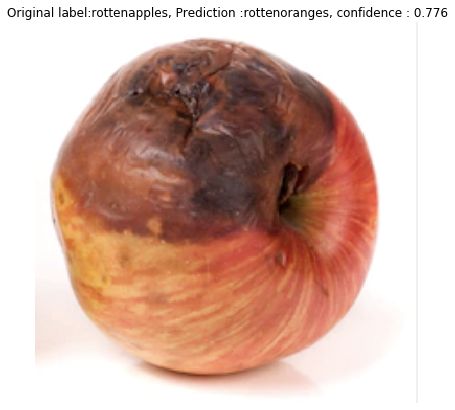

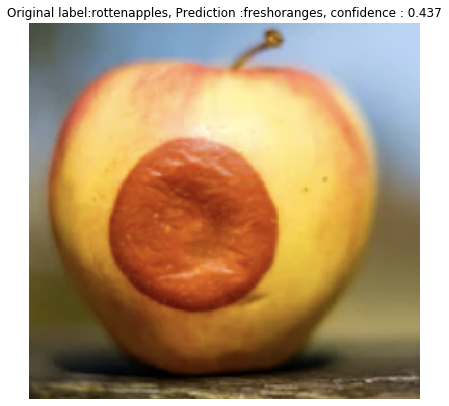

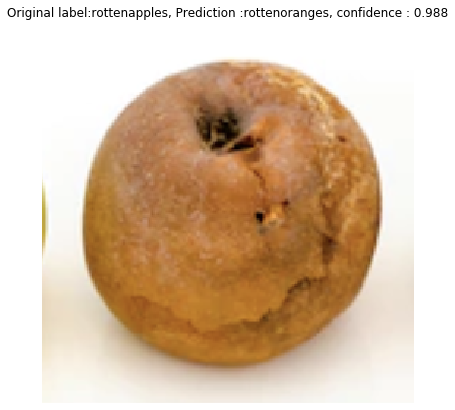

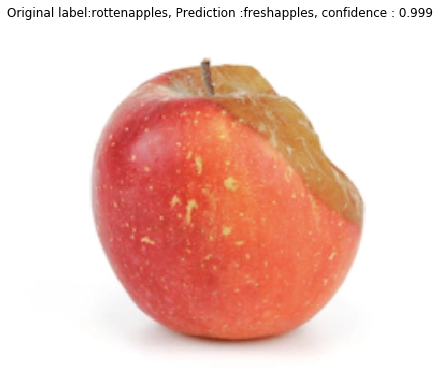

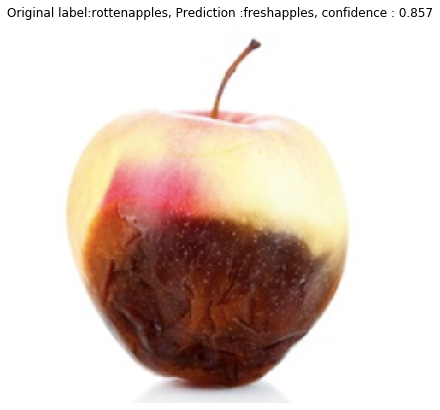

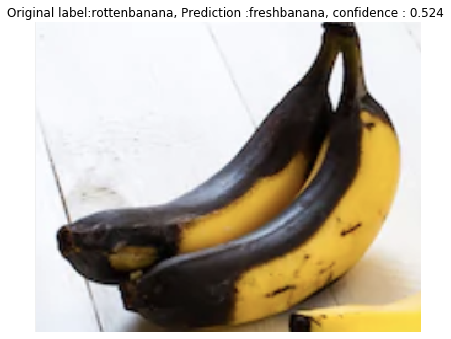

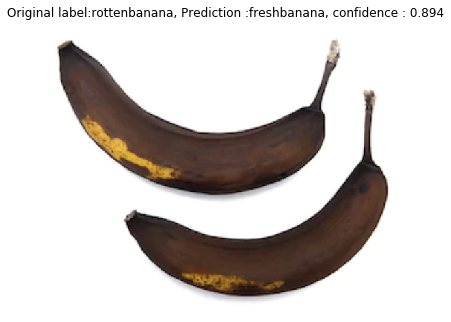

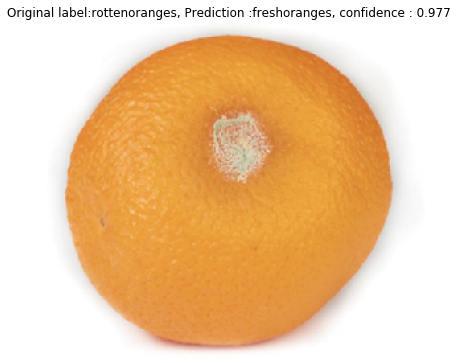

In [0]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

We can see that the test loss is not converging even thought the training loss keeps decreasing. Let us try to train some more layers (Fine-tuning)

## <font style="color:rgb(50,120,229)">Experiment 2 : Train Last 4 layers without data augmentation</font>

In this experiment, we will keep the initial layers fixed and only retrain the last 4 layers. Since the initial layers learn more general features, it is a good practice to freeze the initial layers while fine-tuning the latter layers of the network for the new task.

In [0]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all layers except the last 4
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6b43a3c1d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b43a3c6d8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b43aac668> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6ba6d89e80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b43a2dac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b43fd4710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b43a1e400> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b43a1e4e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b43a15c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b439f2f28> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b43f5b240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

## <font style="color:rgb(50,120,229)">Train the model</font>

In [0]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)



Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.
Epoch 1/20
26/25 [==============================] - 51s 2s/step - loss: 1.4159 - acc: 0.5283 - val_loss: 0.4875 - val_acc: 0.8341
Epoch 2/20
26/25 [==============================] - 30s 1s/step - loss: 0.3529 - acc: 0.8759 - val_loss: 0.2991 - val_acc: 0.8924
Epoch 3/20
26/25 [==============================] - 30s 1s/step - loss: 0.2477 - acc: 0.9154 - val_loss: 0.2483 - val_acc: 0.9283
Epoch 4/20
26/25 [==============================] - 31s 1s/step - loss: 0.2263 - acc: 0.9356 - val_loss: 0.1736 - val_acc: 0.9462
Epoch 5/20
26/25 [==============================] - 30s 1s/step - loss: 0.0765 - acc: 0.9775 - val_loss: 0.1568 - val_acc: 0.9507
Epoch 6/20
26/25 [==============================] - 30s 1s/step - loss: 0.0346 - acc: 0.9876 - val_loss: 0.7773 - val_acc: 0.8296
Epoch 7/20
26/25 [==============================] - 30s 1s/step - loss: 0.1037 - acc: 0.9783 - val_loss: 0.2014 - val_acc: 0.9462
Epoch 8

In [0]:
# Save the Model
model.save('last4_layers.h5')

# you can also download the model to your pc from the files tab on the left

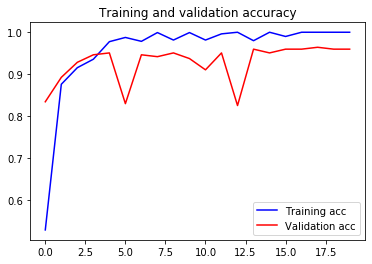

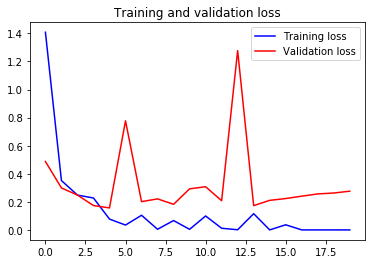

In [0]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## <font style="color:rgb(50,120,229)">Show the errors</font>



Found 223 images belonging to 6 classes.
12/11 [================================] - 3s 218ms/step
No of errors = 9/223


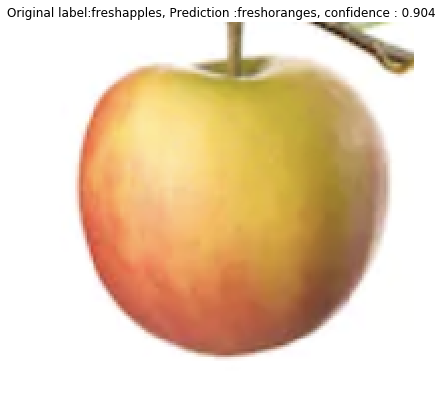

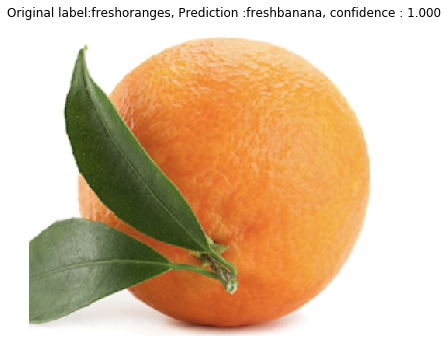

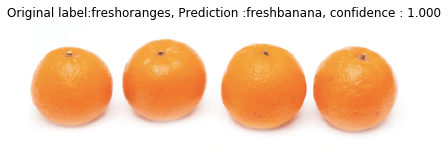

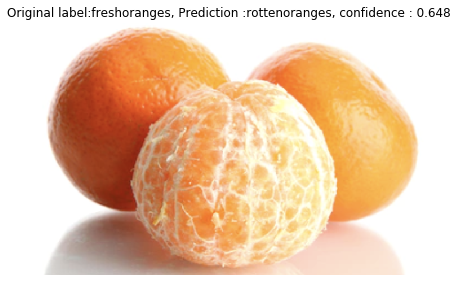

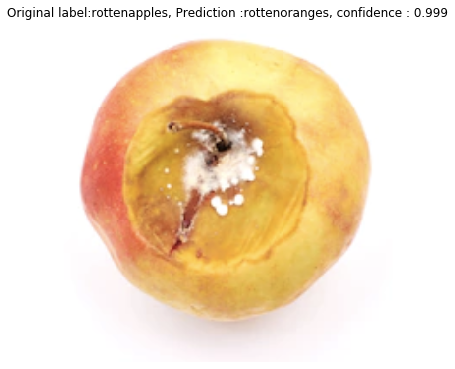

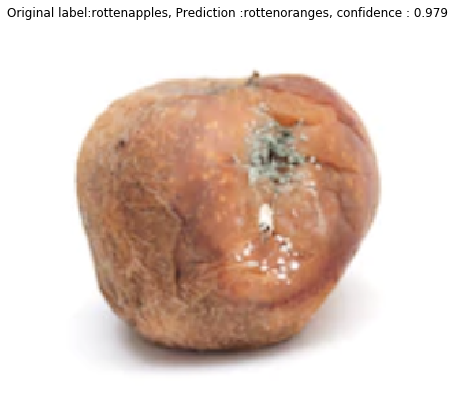

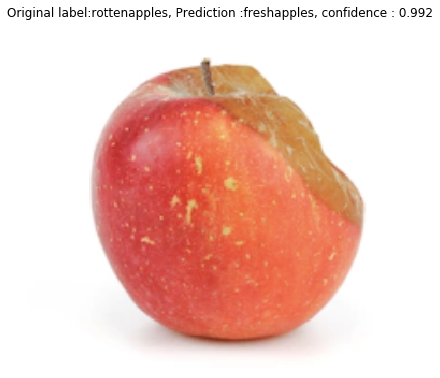

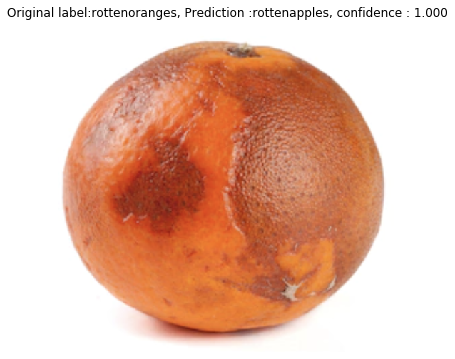

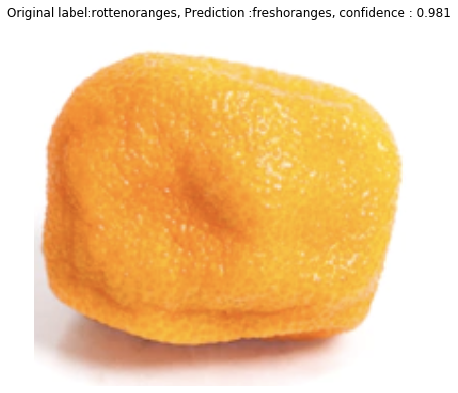

In [0]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

## <font style="color:rgb(50,120,229)">Experiment 3 : Train last 8 layers with data augmentation</font>

We do this experiment to check if we can get even better results than the previous experiment. We train more number of layers and also use data augmentation while training.

In [0]:

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6b42b1bac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b42b1b898> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6ba6d89a20> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b42939f28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b42939ef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b428da7b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b428e5a90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b428e5b70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b4288a320> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6b428935f8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6b4289e8d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

## <font style="color:rgb(50,120,229)">Train the model</font>
Here we will be using the imageDataGenerator for data augmentation.

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
# NOTE that we have multiplied the steps_per_epoch by 2. This is because we are using data augmentation.
history = model.fit_generator(
      train_generator,
      steps_per_epoch=2*train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)



Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.
Epoch 1/20
52/51 [==============================] - 59s 1s/step - loss: 1.0910 - acc: 0.6071 - val_loss: 0.5651 - val_acc: 0.8251
Epoch 2/20
52/51 [==============================] - 58s 1s/step - loss: 0.4003 - acc: 0.8635 - val_loss: 0.4388 - val_acc: 0.8520
Epoch 3/20
52/51 [==============================] - 58s 1s/step - loss: 0.2129 - acc: 0.9240 - val_loss: 0.1578 - val_acc: 0.9686
Epoch 4/20
52/51 [==============================] - 57s 1s/step - loss: 0.1743 - acc: 0.9488 - val_loss: 0.4229 - val_acc: 0.9013
Epoch 5/20
52/51 [==============================] - 57s 1s/step - loss: 0.1386 - acc: 0.9566 - val_loss: 0.1654 - val_acc: 0.9596
Epoch 6/20
52/51 [==============================] - 57s 1s/step - loss: 0.0928 - acc: 0.9713 - val_loss: 0.2990 - val_acc: 0.9372
Epoch 7/20
52/51 [==============================] - 57s 1s/step - loss: 0.0874 - acc: 0.9744 - val_loss: 0.2003 - val_acc: 0.9327
Epoch 8

In [0]:
# Save the Model
model.save('da_last4_layers.h5')

# You can also download it from the files tab on the left

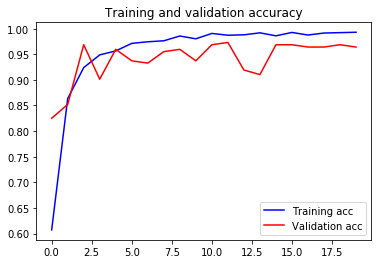

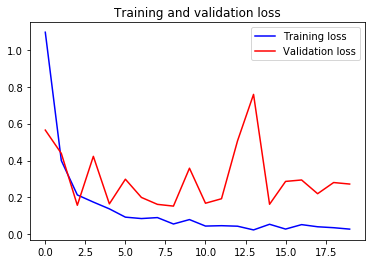

In [0]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## <font style="color:rgb(50,120,229)">Show the errors</font>



Found 223 images belonging to 6 classes.
12/11 [================================] - 3s 218ms/step
No of errors = 8/223


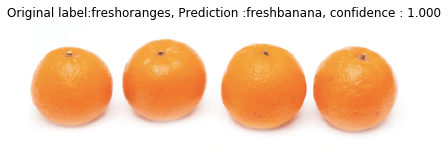

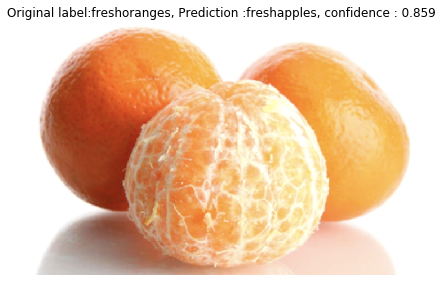

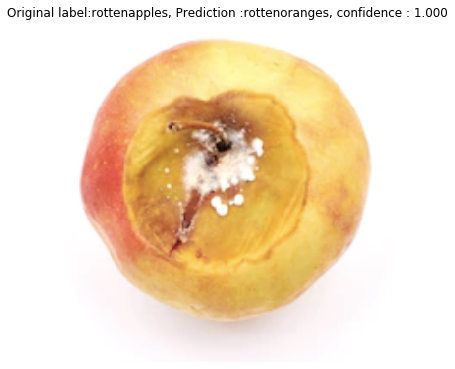

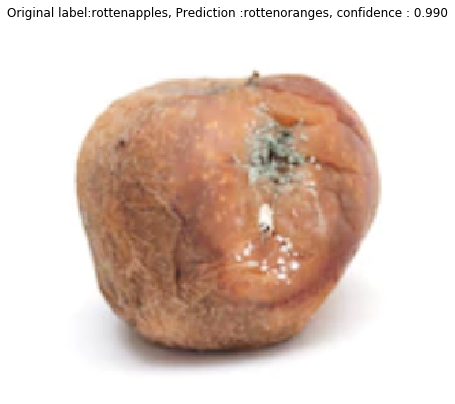

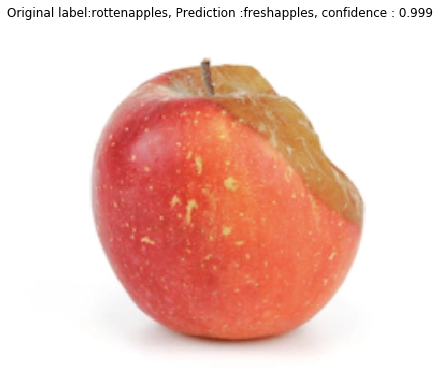

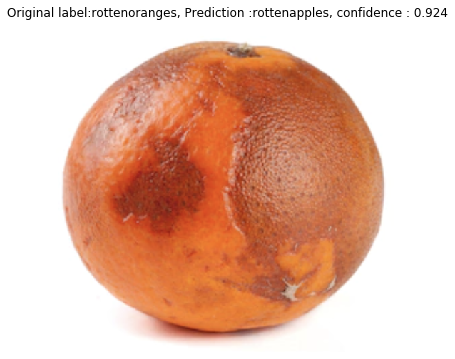

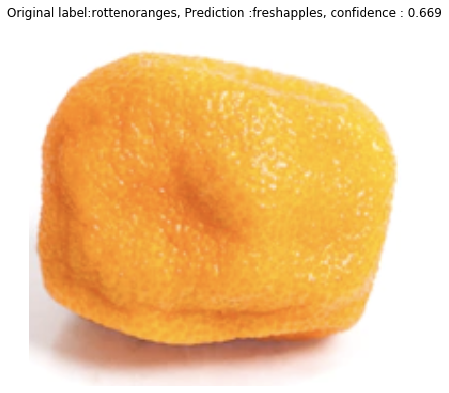

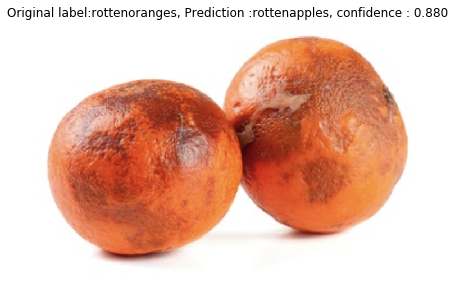

In [0]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In experiment 2, there were signs of overfitting, which are reduced to an extent by using data augmentation. You should try and run for more number of epochs to see the effect of data augmentation.

## <font style="color:rgb(50,120,229)">Exercise</font>

1. Try to use a different dataset and see if the same code and network works for the new dataset.
1. Try unfreezing more layers and see how the accuracy improves.
1. Try with some different model instead of VGG